In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
pct_close = pd.read_parquet("../../db/tw/pdata/close_pct.parquet")
pct_close_w = pct_close.resample("W-FRI").sum()
factor = pd.read_parquet("../../db/factor/F_ARMA_2020_20240628.parquet")



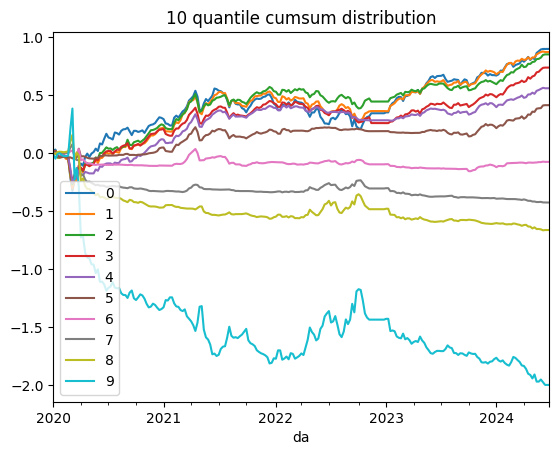

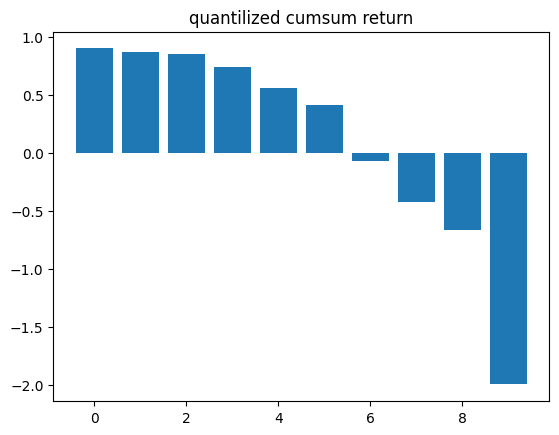

In [8]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
quantile = 10
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-2)

index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot(title="10 quantile cumsum distribution")
plt.show()

"""
0: AR預測值最高; 9: 最低 (number of stocks in thje stock pool: 1013; stocks per quantile: 100, 等權做多報酬)
"""
plt.bar(quantilized_cumsum.columns, quantilized_cumsum.iloc[-1, :])
plt.title("quantilized cumsum return")
plt.show()
